# SWC Case

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.10f}'.format

from sklearn import tree
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import StackingClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, roc_curve

from sklearn.manifold import TSNE
import optuna #Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning.
from optuna.samplers import TPESampler
import pickle
from sklearn.feature_selection import VarianceThreshold


In [7]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2

2023-11-15 23:38:06.130301: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_data = pd.read_csv('train_data_swc.csv')
test_data = pd.read_csv('test_data_swc.csv') # this is not validation data
example_data = pd.read_csv('example.csv')

In [ ]:
print('number of data points in the train data: ' , len(train_data))
print('number of data points in the test data: ' , len(test_data))

In [ ]:
train_data.head(5)

In [ ]:
test_data.head(5)

In [ ]:
class_counts = train_data['y'].value_counts()
class_percentages = class_counts / len(train_data) * 100
plt.bar(class_percentages.index, class_percentages)
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.title('Class Distribution in the Dataset')
plt.show()

## Preprocessing

### Correlation among Features

In [ ]:
corr_matrix = train_data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

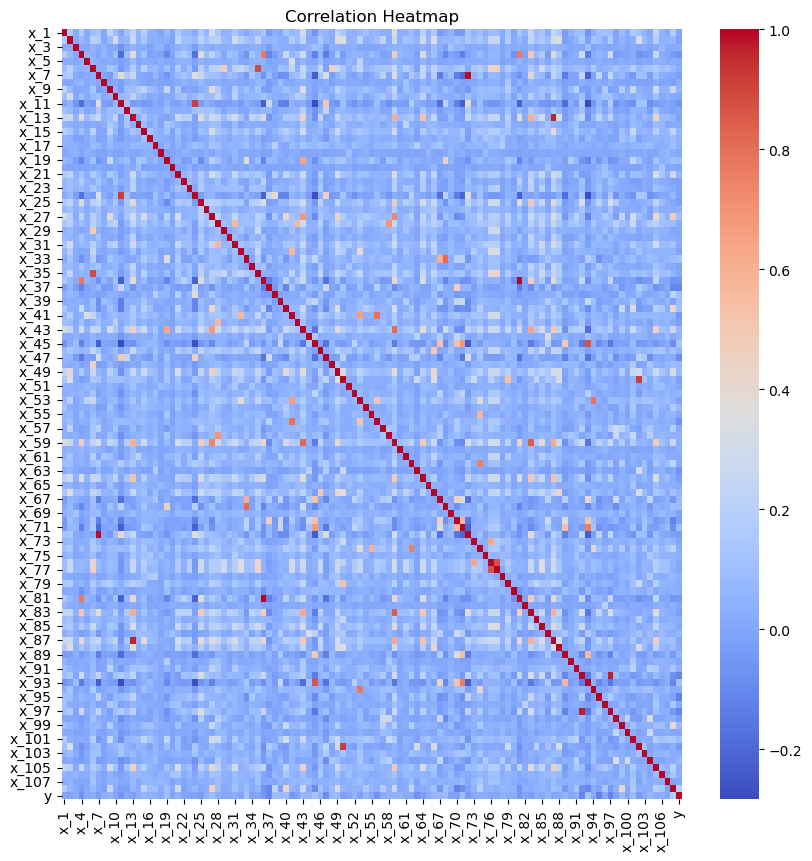

In [3]:
train_classes_two_and_three = train_data[(train_data['y'] == 2) | (train_data['y'] == 3)]
corr_matrix = train_classes_two_and_three = train_data[(train_data['y'] == 2) | (train_data['y'] == 3)].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:

corr_matrix = train_data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
train_data[train_data.columns[1:]].corr()['y'][:].sort_values(ascending=False)

## Feature Engineering

### Variance Threshold

In [3]:
X = train_data.iloc[:,0:107]
vt = VarianceThreshold(threshold=0.05)
vt.fit(X)

# find the features that meet the variance threshold
mask = vt.get_support()
chosen_features = list(X.loc[:, mask].columns)
removed_features = [feature for feature in X.columns if feature not in chosen_features]

# show the chosen and removed features
print('Chosen features: ', chosen_features)
print('Removed features: ', removed_features)

Chosen features:  ['x_2', 'x_4', 'x_6', 'x_7', 'x_8', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_19', 'x_20', 'x_21', 'x_23', 'x_24', 'x_25', 'x_27', 'x_28', 'x_29', 'x_30', 'x_31', 'x_32', 'x_33', 'x_35', 'x_36', 'x_37', 'x_38', 'x_39', 'x_40', 'x_41', 'x_43', 'x_44', 'x_45', 'x_46', 'x_47', 'x_49', 'x_50', 'x_52', 'x_53', 'x_54', 'x_55', 'x_56', 'x_57', 'x_58', 'x_59', 'x_60', 'x_62', 'x_64', 'x_66', 'x_67', 'x_68', 'x_69', 'x_70', 'x_71', 'x_72', 'x_73', 'x_74', 'x_75', 'x_76', 'x_77', 'x_78', 'x_80', 'x_81', 'x_83', 'x_84', 'x_85', 'x_86', 'x_87', 'x_88', 'x_89', 'x_90', 'x_92', 'x_93', 'x_94', 'x_97', 'x_98', 'x_100', 'x_101', 'x_102', 'x_103', 'x_104', 'x_105']
Removed features:  ['x_1', 'x_3', 'x_5', 'x_9', 'x_18', 'x_22', 'x_26', 'x_34', 'x_42', 'x_48', 'x_51', 'x_61', 'x_63', 'x_65', 'x_79', 'x_82', 'x_91', 'x_95', 'x_96', 'x_99', 'x_106', 'x_107']


In [4]:
if(True):    
    test_data = test_data[chosen_features]
    print(len(chosen_features))
    chosen_features.append('y')
    print(len(chosen_features))
    train_data = train_data[chosen_features]
     

85
86


### TSNE

In [3]:

X_tsne = TSNE(n_components=2, learning_rate="auto", perplexity=150, verbose=1).fit_transform(train_data.drop(['y'], axis = 1))

[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 62500 samples in 0.052s...
[t-SNE] Computed neighbors for 62500 samples in 18.747s...
[t-SNE] Computed conditional probabilities for sample 1000 / 62500
[t-SNE] Computed conditional probabilities for sample 2000 / 62500
[t-SNE] Computed conditional probabilities for sample 3000 / 62500
[t-SNE] Computed conditional probabilities for sample 4000 / 62500
[t-SNE] Computed conditional probabilities for sample 5000 / 62500
[t-SNE] Computed conditional probabilities for sample 6000 / 62500
[t-SNE] Computed conditional probabilities for sample 7000 / 62500
[t-SNE] Computed conditional probabilities for sample 8000 / 62500
[t-SNE] Computed conditional probabilities for sample 9000 / 62500
[t-SNE] Computed conditional probabilities for sample 10000 / 62500
[t-SNE] Computed conditional probabilities for sample 11000 / 62500
[t-SNE] Computed conditional probabilities for sample 12000 / 62500
[t-SNE] Computed conditional probabilities for s

In [9]:
print(type(X_tsne))
# convert X_tsne to dataframe
X_tsne_df = pd.DataFrame(X_tsne)
# add X_tsne_df to train_data and test_data by changing the column names as tsn1_1 and tsn1_2
train_data['tsn1_1'] = X_tsne_df[0] 
train_data['tsn1_2'] = X_tsne_df[1]
test_data['tsn1_1'] = X_tsne_df[0]
test_data['tsn1_2'] = X_tsne_df[1]

<class 'numpy.ndarray'>


In [11]:
# print the shape of train_data and test_data and add explanation in the print statement
print('Shape of train_data: ', train_data.shape)
print('Shape of test_data: ', test_data.shape)

Shape of train_data:  (62500, 111)
Shape of test_data:  (150000, 110)


#### add the tsne features to the train data

if(True):    
    test_data = test_data[chosen_features]
    print(len(chosen_features))
    chosen_features.append('y')
    print(len(chosen_features))
    train_data = train_data[chosen_features]

In [ ]:
for i in [100, 200, 300, 400, 500]:
    X_tsne = TSNE(learning_rate="auto", perplexity=i).fit_transform(train_data.drop(['y'], axis = 1))

In [7]:
classes = list(train_data['y'].unique())

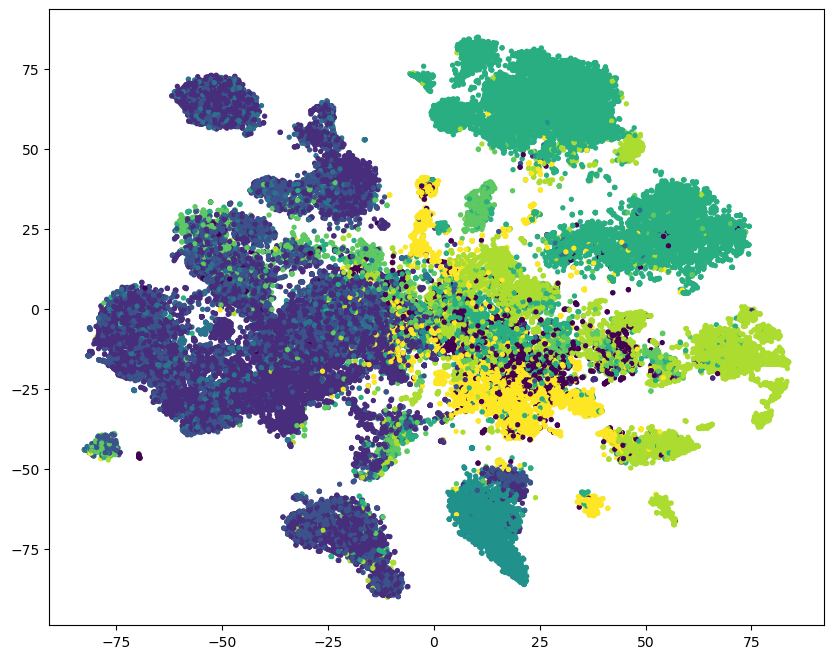

In [6]:

plt.figure(figsize=(10, 8))

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=train_data['y'], s=8)

NameError: name 'classes' is not defined

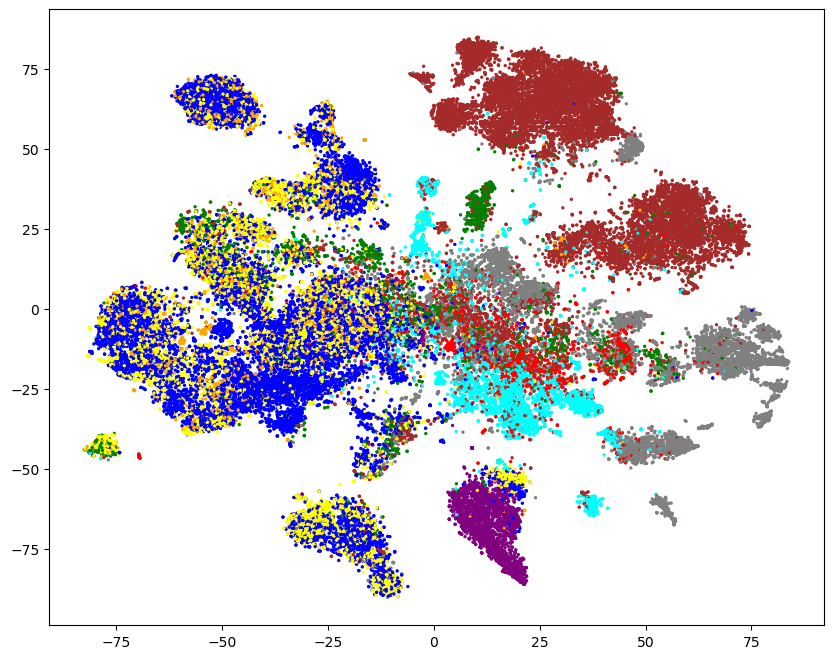

In [5]:

plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'yellow', 'orange', 'purple', 'brown', 'green', 'gray', 'cyan']
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=train_data['y'], s=2, cmap=ListedColormap(colors))
plt.legend(classes)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


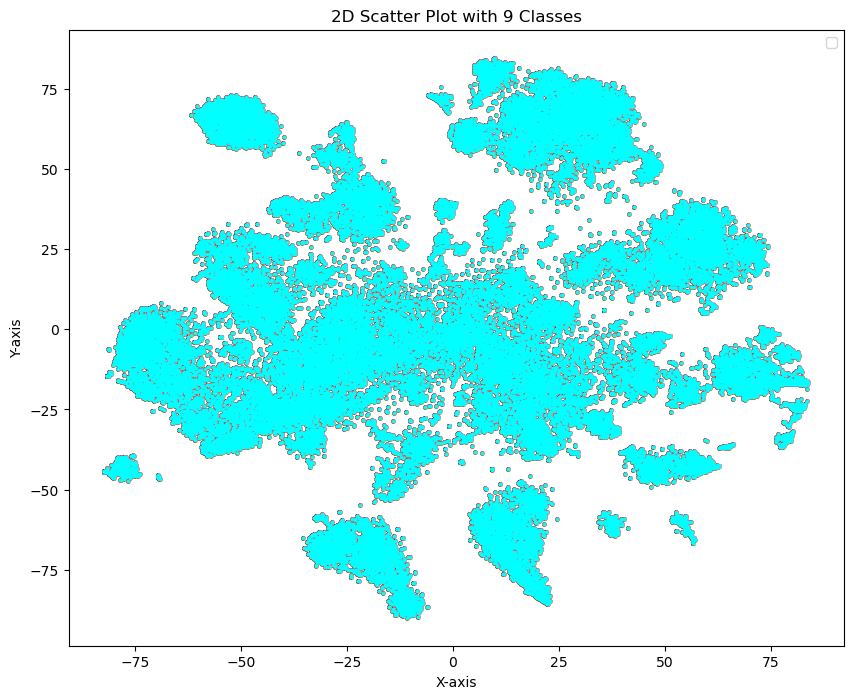

In [11]:
class_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan']
class_markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p', '*']

# Create a scatter plot
plt.figure(figsize=(10, 8))

for i in range(9):
    class_df = train_data[train_data['y'] == i]
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], label=f'Class {i}', color=class_colors[i], marker=class_markers[i], s=3)

# Adjust plot settings
plt.title('2D Scatter Plot with 9 Classes')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

## ML Models

In [12]:
X = train_data.drop(['y'], axis = 1)
y = train_data['y']
number_f_class = len(y.unique())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 13)
print("number of classes: ", number_f_class)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

number of classes:  9
(50000, 110) (12500, 110) (50000,) (12500,)


### K-nearest Classifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 1).fit(X_train, y_train) 

predicted = knn.predict(X_test)
predicted_train = knn.predict(X_train)

accuracy_train = accuracy_score(predicted_train, y_train)
accuracy_test = accuracy_score(predicted, y_test)

print(f'Accuracy_train: {accuracy_train}')
print(f'Accuracy_test: {accuracy_test}')

### Naive Bayes Classifier

In [ ]:
gnb = GaussianNB().fit(X_train, y_train) 
predicted = gnb.predict(X_test)
predicted_train = gnb.predict(X_train)

accuracy_train = accuracy_score(predicted_train, y_train)
accuracy_test = accuracy_score(predicted, y_test)

print(f'Accuracy_train: {accuracy_train}')
print(f'Accuracy_test: {accuracy_test}')

### SVM - Linear Kernel

In [ ]:
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 
svm_predictions = svm_model_linear.predict(X_test) 

svm_predictions_train = svm_model_linear.predict(X_train)

# model accuracy for X_train
accuracy_svmlinear_train = svm_model_linear.score(X_train, y_train) 

# model accuracy for X_test   
accuracy_svmlinear_test = svm_model_linear.score(X_test, y_test) 

print(f'Accuracy_train: {accuracy_svmlinear_train}')
print(f'Accuracy_test: {accuracy_svmlinear_test}')

### Decision Tree Model

In [34]:
class_weights = {1: 1, 2: 1, 3: 2, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1}
dt = DecisionTreeClassifier(random_state = 11, max_depth = 18,class_weight=class_weights)
dt.fit(X_train, y_train)
predicted = dt.predict(X_test)
predicted_train = dt.predict(X_train)
accuracy_train = accuracy_score(predicted_train, y_train)
accuracy_test = accuracy_score(predicted, y_test)
print(f'Accuracy_train: {accuracy_train}')
print(f'Accuracy_test: {accuracy_test}')

Accuracy_train: 0.79524
Accuracy_test: 0.702


In [ ]:
#classes = [str(x) for x in train_data['y'].unique().tolist()]
#fig = plt.figure(figsize = (20, ))
#_ = tree.plot_tree(model, feature_names = X.columns.values.tolist(),class_names = classes, filled = True)
#fig.savefig("decision_tree.png")

### Balanced Bagging Classifier

In [35]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
#Create an instance
classifier = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='not majority',
                                replacement=False,
                                random_state=12)
classifier.fit(X_train, y_train)
predicted = classifier.predict(X_test)
predicted_train = classifier.predict(X_train)
accuracy_train = accuracy_score(predicted_train, y_train)
accuracy_test = accuracy_score(predicted, y_test)
print(f'Accuracy_train: {accuracy_train}')
print(f'Accuracy_test: {accuracy_test}')
print(confusion_matrix(y_test, predicted))
print(confusion_matrix(y_train, predicted_train))



Accuracy_train: 0.8652
Accuracy_test: 0.7508
[[ 239   18    4    5    3   12   19   32   48]
 [   8 3112   91   60    5    7   27    6    4]
 [   7 1170  328   52    2    3   32    2    2]
 [   1  264   12  254    1   12    7    2    0]
 [   1   15    0    2  530    0    2    0    2]
 [  99   57   11   33    6 2551   76   45   57]
 [  34   80   21   18    5   22  335   22    5]
 [ 120   59   10   11    7   47   57 1282   37]
 [ 117   50    3    5    0   18   11   32  754]]
[[ 1562     0     0     0     0     2     3     1     6]
 [    0 12952     3     4     0     0     4     0     0]
 [   19  3631  2613   123     2     9    79     7     8]
 [    0   204    13  1939     1     6     2     0     0]
 [    1    16     0     0  2192     0     1     0     1]
 [  279   216    39   116    11 10079   225   191   173]
 [   19    77     8     9     2    17  2192     7     1]
 [  272   183    26    21    11   115   128  6066    88]
 [  129    90     2     6     9    39    23    62  3665]]


### FeedForward Neural Network

In [4]:
hidden_layer_sizes = [100,150,250]
max_iter = [2500]
learning_rate = [0.001, 0.005, 0.01]
alpha=[0.001, 0.0001]
activation_funcs = ['logistic'] 
solvers = ['lbfgs']

In [5]:
settings_list = []
for hidden_layer in hidden_layer_sizes:
    for iter in max_iter:
        for learn_rate in learning_rate:
            for active_func in activation_funcs:
                for solv in solvers:
                    for alp in alpha:
                        mlp = MLPClassifier(hidden_layer_sizes=(hidden_layer,), max_iter=iter, learning_rate_init=learn_rate, activation=active_func, solver=solv, alpha=alp, random_state=1)
                        mlp.fit(X_train, y_train)
                        predicted = mlp.predict(X_test)
                        predicted_train = mlp.predict(X_train)
                        accuracy_train = accuracy_score(predicted_train, y_train)
                        accuracy_test = accuracy_score(predicted, y_test)
                        # print(f'Accuracy_train: {accuracy_train}')
                        # print(f'Accuracy_test: {accuracy_test}')
                        y_proba = mlp.predict_proba(X_test)
                        log_loss_test = log_loss(y_test, y_proba)
                        y_proba_train = mlp.predict_proba(X_train)
                        log_loss_train = log_loss(y_train, y_proba_train)
                        settings_dict = {'hl': hidden_layer, 'mi': iter, 'lr': learn_rate, 'af': active_func, 'sv': solv, 'accuracy_train': accuracy_train, 'accuracy_test': accuracy_test, 'log_loss_test': log_loss_test, 'log_loss_train': log_loss_train}
                        settings_list.append(settings_dict)
                        print(settings_list[-1])
                    

{'hl': 100, 'mi': 2500, 'lr': 0.001, 'af': 'logistic', 'sv': 'lbfgs', 'accuracy_train': 0.93196, 'accuracy_test': 0.7652, 'log_loss_test': 1.9313854874473317, 'log_loss_train': 0.17750138691765371}
{'hl': 100, 'mi': 2500, 'lr': 0.001, 'af': 'logistic', 'sv': 'lbfgs', 'accuracy_train': 0.93168, 'accuracy_test': 0.75928, 'log_loss_test': 1.874738569735863, 'log_loss_train': 0.18201320918434086}


KeyboardInterrupt: 

In [ ]:
activation_funcs = ['identity', 'logistic', 'tanh', 'relu'] 
solvers = ['lbfgs', 'sgd', 'adam']
nn = MLPClassifier(hidden_layer_sizes=(500), activation='logistic', solver='lbfgs', alpha=0.001,
                    batch_size='auto', learning_rate='constant', learning_rate_init=0.005, power_t=0.5, max_iter=1400, 
                    shuffle=True, random_state=11, tol=0.000001, verbose=True, warm_start=False, momentum=0.8, nesterovs_momentum=True, early_stopping=True, 
                    validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                    n_iter_no_change=25, max_fun=15000)
nn.fit(X_train, y_train)
score = nn.score(X_test, y_test)
print("Accuracy:", score)
y_pred_test = nn.predict(X_test)
y_pred_train = nn.predict(X_train)
accuracy_train = accuracy_score(y_pred_train, y_train)
accuracy_test = accuracy_score(y_pred_test, y_test)
print(f'Accuracy_train: {accuracy_train}')
print(f'Accuracy_test: {accuracy_test}')
print(confusion_matrix(y_train, y_pred_train))
print(confusion_matrix(y_test, y_pred_test))


y_proba = nn.predict_proba(X_test)

# Evaluate the log loss of the stacking classifier (for probabilistic predictions)
log_loss_value = log_loss(y_test, y_proba)
print(f"Neural Network Log Loss: {log_loss_value}")


### LightGBM Model

In [14]:
def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "num_class": number_f_class,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.LGBMClassifier(**param)
    gbm.fit(X_train, y_train)
    preds = gbm.predict(X_test)
    accuracy_test = accuracy_score(y_test, preds)
    return accuracy_test

In [17]:

#this part has already been run and we took the required results which are the best parameters
sampler = TPESampler(seed=10)
study = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)
print('Best parameters:', study.best_params)
print('Best value:', study.best_value)
print('Best trial:', study.best_trial)

[I 2023-11-16 13:12:44,464] A new study created in memory with name: lightgbm
[I 2023-11-16 13:13:34,748] Trial 0 finished with value: 0.83312 and parameters: {'lambda_l1': 0.08747537025773001, 'lambda_l2': 1.537331564587801e-08, 'num_leaves': 163, 'feature_fraction': 0.8492823295231671, 'bagging_fraction': 0.6991042073815543, 'bagging_freq': 2, 'min_child_samples': 24}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.8112158910206784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8112158910206784
[LightGBM] [Warning] lambda_l1 is set=0.0699481785242808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0699481785242808
[LightGBM] [Warning] bagging_fraction is set=0.972036007716962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.972036007716962
[LightGBM] [Warning] lambda_l2 is set=3.32657660618516e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.32657660618516e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-11-16 13:13:46,794] Trial 1 finished with value: 0.8164 and parameters: {'lambda_l1': 0.0699481785242808, 'lambda_l2': 3.32657660618516e-07, 'num_leaves': 24, 'feature_fraction': 0.8112158910206784, 'bagging_fraction': 0.972036007716962, 'bagging_freq': 1, 'min_child_samples': 54}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.5751256409023799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5751256409023799
[LightGBM] [Warning] lambda_l1 is set=0.20586790968905005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20586790968905005
[LightGBM] [Warning] bagging_fraction is set=0.9506644735077661, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9506644735077661
[LightGBM] [Warning] lambda_l2 is set=0.003256376421394008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003256376421394008
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-11-16 13:36:39,794] Trial 2 finished with value: 0.83152 and parameters: {'lambda_l1': 0.20586790968905005, 'lambda_l2': 0.003256376421394008, 'num_leaves': 186, 'feature_fraction': 0.5751256409023799, 'bagging_fraction': 0.9506644735077661, 'bagging_freq': 6, 'min_child_samples': 57}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.6650999046537976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6650999046537976
[LightGBM] [Warning] lambda_l1 is set=1.9034015928564192e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9034015928564192e-07
[LightGBM] [Warning] bagging_fraction is set=0.6604083959999762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6604083959999762
[LightGBM] [Warning] lambda_l2 is set=2.2912202578440842e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2912202578440842e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-11-16 13:37:42,856] Trial 3 finished with value: 0.83064 and parameters: {'lambda_l1': 1.9034015928564192e-07, 'lambda_l2': 2.2912202578440842e-05, 'num_leaves': 173, 'feature_fraction': 0.6650999046537976, 'bagging_fraction': 0.6604083959999762, 'bagging_freq': 5, 'min_child_samples': 54}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.7129882914361805, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7129882914361805
[LightGBM] [Warning] lambda_l1 is set=0.007137968669448066, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007137968669448066
[LightGBM] [Warning] bagging_fraction is set=0.945189328485201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.945189328485201
[LightGBM] [Warning] lambda_l2 is set=0.0025665550309028774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0025665550309028774
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-16 13:38:41,356] Trial 4 finished with value: 0.82704 and parameters: {'lambda_l1': 0.007137968669448066, 'lambda_l2': 0.0025665550309028774, 'num_leaves': 207, 'feature_fraction': 0.7129882914361805, 'bagging_fraction': 0.945189328485201, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.42813779163354987, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42813779163354987
[LightGBM] [Warning] lambda_l1 is set=5.085111847677709e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.085111847677709e-06
[LightGBM] [Warning] bagging_fraction is set=0.7757722889868355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7757722889868355
[LightGBM] [Warning] lambda_l2 is set=1.0613515458050516e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0613515458050516e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-16 13:40:02,081] Trial 5 finished with value: 0.82936 and parameters: {'lambda_l1': 5.085111847677709e-06, 'lambda_l2': 1.0613515458050516e-07, 'num_leaves': 213, 'feature_fraction': 0.42813779163354987, 'bagging_fraction': 0.7757722889868355, 'bagging_freq': 4, 'min_child_samples': 83}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.8527886149179144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8527886149179144
[LightGBM] [Warning] lambda_l1 is set=6.173448891970491e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.173448891970491e-07
[LightGBM] [Warning] bagging_fraction is set=0.5775770241278072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5775770241278072
[LightGBM] [Warning] lambda_l2 is set=0.5148168134404182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5148168134404182
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-11-16 13:40:41,105] Trial 6 finished with value: 0.82688 and parameters: {'lambda_l1': 6.173448891970491e-07, 'lambda_l2': 0.5148168134404182, 'num_leaves': 91, 'feature_fraction': 0.8527886149179144, 'bagging_fraction': 0.5775770241278072, 'bagging_freq': 7, 'min_child_samples': 36}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.892663394702157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.892663394702157
[LightGBM] [Warning] lambda_l1 is set=3.055927730910031e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.055927730910031e-07
[LightGBM] [Warning] bagging_fraction is set=0.4906912117855383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4906912117855383
[LightGBM] [Warning] lambda_l2 is set=3.4100692264414245e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4100692264414245e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-16 13:40:56,353] Trial 7 finished with value: 0.81576 and parameters: {'lambda_l1': 3.055927730910031e-07, 'lambda_l2': 3.4100692264414245e-05, 'num_leaves': 25, 'feature_fraction': 0.892663394702157, 'bagging_fraction': 0.4906912117855383, 'bagging_freq': 3, 'min_child_samples': 95}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.5508244805242356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5508244805242356
[LightGBM] [Warning] lambda_l1 is set=7.738009776978926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.738009776978926
[LightGBM] [Warning] bagging_fraction is set=0.7584229889385306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7584229889385306
[LightGBM] [Warning] lambda_l2 is set=0.00012786183233975197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012786183233975197
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-11-16 13:41:26,286] Trial 8 finished with value: 0.81872 and parameters: {'lambda_l1': 7.738009776978926, 'lambda_l2': 0.00012786183233975197, 'num_leaves': 212, 'feature_fraction': 0.5508244805242356, 'bagging_fraction': 0.7584229889385306, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.44776785409357855, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44776785409357855
[LightGBM] [Warning] lambda_l1 is set=0.0020502757114657026, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0020502757114657026
[LightGBM] [Warning] bagging_fraction is set=0.583275951005691, subsample=1.0 will be ignored. Current value: bagging_fraction=0.583275951005691
[LightGBM] [Warning] lambda_l2 is set=2.2570225857344917e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2570225857344917e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-16 13:41:58,896] Trial 9 finished with value: 0.82832 and parameters: {'lambda_l1': 0.0020502757114657026, 'lambda_l2': 2.2570225857344917e-08, 'num_leaves': 93, 'feature_fraction': 0.44776785409357855, 'bagging_fraction': 0.583275951005691, 'bagging_freq': 3, 'min_child_samples': 79}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.93133462155998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.93133462155998
[LightGBM] [Warning] lambda_l1 is set=9.937006757793243e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.937006757793243e-05
[LightGBM] [Warning] bagging_fraction is set=0.4291656249529019, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4291656249529019
[LightGBM] [Warning] lambda_l2 is set=1.7042201212211792e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7042201212211792e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-11-16 13:42:54,316] Trial 10 finished with value: 0.82864 and parameters: {'lambda_l1': 9.937006757793243e-05, 'lambda_l2': 1.7042201212211792e-08, 'num_leaves': 250, 'feature_fraction': 0.93133462155998, 'bagging_fraction': 0.4291656249529019, 'bagging_freq': 1, 'min_child_samples': 7}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.9590705629064558, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9590705629064558
[LightGBM] [Warning] lambda_l1 is set=0.255026001063559, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.255026001063559
[LightGBM] [Warning] bagging_fraction is set=0.880491019192378, subsample=1.0 will be ignored. Current value: bagging_fraction=0.880491019192378
[LightGBM] [Warning] lambda_l2 is set=0.006572397182875073, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006572397182875073
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-11-16 13:43:21,497] Trial 11 finished with value: 0.83104 and parameters: {'lambda_l1': 0.255026001063559, 'lambda_l2': 0.006572397182875073, 'num_leaves': 146, 'feature_fraction': 0.9590705629064558, 'bagging_fraction': 0.880491019192378, 'bagging_freq': 5, 'min_child_samples': 31}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.7626577286341211, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7626577286341211
[LightGBM] [Warning] lambda_l1 is set=9.696952239896364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.696952239896364
[LightGBM] [Warning] bagging_fraction is set=0.8109786004168796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8109786004168796
[LightGBM] [Warning] lambda_l2 is set=1.1850336053397283e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1850336053397283e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-11-16 13:43:30,952] Trial 12 finished with value: 0.82168 and parameters: {'lambda_l1': 9.696952239896364, 'lambda_l2': 1.1850336053397283e-06, 'num_leaves': 128, 'feature_fraction': 0.7626577286341211, 'bagging_fraction': 0.8109786004168796, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.6302482400741398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6302482400741398
[LightGBM] [Warning] lambda_l1 is set=0.128070987555928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.128070987555928
[LightGBM] [Warning] bagging_fraction is set=0.9979000611889808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9979000611889808
[LightGBM] [Warning] lambda_l2 is set=3.1488957830792917e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1488957830792917e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-11-16 13:43:48,596] Trial 13 finished with value: 0.8316 and parameters: {'lambda_l1': 0.128070987555928, 'lambda_l2': 3.1488957830792917e-06, 'num_leaves': 180, 'feature_fraction': 0.6302482400741398, 'bagging_fraction': 0.9979000611889808, 'bagging_freq': 2, 'min_child_samples': 66}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.9949145705632824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9949145705632824
[LightGBM] [Warning] lambda_l1 is set=0.0002204647569621731, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002204647569621731
[LightGBM] [Warning] bagging_fraction is set=0.8494935390135345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8494935390135345
[LightGBM] [Warning] lambda_l2 is set=2.020286818652814e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.020286818652814e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-11-16 13:44:06,651] Trial 14 finished with value: 0.8296 and parameters: {'lambda_l1': 0.0002204647569621731, 'lambda_l2': 2.020286818652814e-06, 'num_leaves': 137, 'feature_fraction': 0.9949145705632824, 'bagging_fraction': 0.8494935390135345, 'bagging_freq': 2, 'min_child_samples': 72}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.7855161626764755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7855161626764755
[LightGBM] [Warning] lambda_l1 is set=0.00821080556368022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00821080556368022
[LightGBM] [Warning] bagging_fraction is set=0.6785541529456637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6785541529456637
[LightGBM] [Warning] lambda_l2 is set=1.338755388304718e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.338755388304718e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-11-16 13:44:33,990] Trial 15 finished with value: 0.83144 and parameters: {'lambda_l1': 0.00821080556368022, 'lambda_l2': 1.338755388304718e-08, 'num_leaves': 251, 'feature_fraction': 0.7855161626764755, 'bagging_fraction': 0.6785541529456637, 'bagging_freq': 2, 'min_child_samples': 18}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.8551154547790135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8551154547790135
[LightGBM] [Warning] lambda_l1 is set=0.4952292404830894, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4952292404830894
[LightGBM] [Warning] bagging_fraction is set=0.7233818624162673, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7233818624162673
[LightGBM] [Warning] lambda_l2 is set=3.342131056914304e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.342131056914304e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-11-16 13:44:44,151] Trial 16 finished with value: 0.83192 and parameters: {'lambda_l1': 0.4952292404830894, 'lambda_l2': 3.342131056914304e-06, 'num_leaves': 94, 'feature_fraction': 0.8551154547790135, 'bagging_fraction': 0.7233818624162673, 'bagging_freq': 2, 'min_child_samples': 42}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.8806110871025721, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8806110871025721
[LightGBM] [Warning] lambda_l1 is set=1.791637892889481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.791637892889481
[LightGBM] [Warning] bagging_fraction is set=0.7206125676545332, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7206125676545332
[LightGBM] [Warning] lambda_l2 is set=1.2835922140834415e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2835922140834415e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-11-16 13:44:53,303] Trial 17 finished with value: 0.8264 and parameters: {'lambda_l1': 1.791637892889481, 'lambda_l2': 1.2835922140834415e-07, 'num_leaves': 95, 'feature_fraction': 0.8806110871025721, 'bagging_fraction': 0.7206125676545332, 'bagging_freq': 1, 'min_child_samples': 42}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.8450480254694216, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8450480254694216
[LightGBM] [Warning] lambda_l1 is set=0.02518322468012766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02518322468012766
[LightGBM] [Warning] bagging_fraction is set=0.6502449232148362, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6502449232148362
[LightGBM] [Warning] lambda_l2 is set=4.2776568414260095e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2776568414260095e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-16 13:45:04,368] Trial 18 finished with value: 0.82888 and parameters: {'lambda_l1': 0.02518322468012766, 'lambda_l2': 4.2776568414260095e-06, 'num_leaves': 55, 'feature_fraction': 0.8450480254694216, 'bagging_fraction': 0.6502449232148362, 'bagging_freq': 4, 'min_child_samples': 45}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.7414409477027485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7414409477027485
[LightGBM] [Warning] lambda_l1 is set=0.5340341456572589, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5340341456572589
[LightGBM] [Warning] bagging_fraction is set=0.7329938868711142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7329938868711142
[LightGBM] [Warning] lambda_l2 is set=3.0125567568553073e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0125567568553073e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-11-16 13:45:17,381] Trial 19 finished with value: 0.82904 and parameters: {'lambda_l1': 0.5340341456572589, 'lambda_l2': 3.0125567568553073e-07, 'num_leaves': 68, 'feature_fraction': 0.7414409477027485, 'bagging_fraction': 0.7329938868711142, 'bagging_freq': 2, 'min_child_samples': 22}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.8117914095783346, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8117914095783346
[LightGBM] [Warning] lambda_l1 is set=0.9893173123941857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9893173123941857
[LightGBM] [Warning] bagging_fraction is set=0.8024077414412601, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8024077414412601
[LightGBM] [Warning] lambda_l2 is set=1.255525910039129e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.255525910039129e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-16 13:45:31,420] Trial 20 finished with value: 0.8284 and parameters: {'lambda_l1': 0.9893173123941857, 'lambda_l2': 1.255525910039129e-07, 'num_leaves': 115, 'feature_fraction': 0.8117914095783346, 'bagging_fraction': 0.8024077414412601, 'bagging_freq': 3, 'min_child_samples': 25}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.6702082797847144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6702082797847144
[LightGBM] [Warning] lambda_l1 is set=0.03843066837642231, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03843066837642231
[LightGBM] [Warning] bagging_fraction is set=0.8966896489336849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8966896489336849
[LightGBM] [Warning] lambda_l2 is set=8.683342908574523e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.683342908574523e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-11-16 13:45:47,093] Trial 21 finished with value: 0.82888 and parameters: {'lambda_l1': 0.03843066837642231, 'lambda_l2': 8.683342908574523e-06, 'num_leaves': 166, 'feature_fraction': 0.6702082797847144, 'bagging_fraction': 0.8966896489336849, 'bagging_freq': 2, 'min_child_samples': 69}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.921128533837357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.921128533837357
[LightGBM] [Warning] lambda_l1 is set=0.10914523968742791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10914523968742791
[LightGBM] [Warning] bagging_fraction is set=0.9914495619487126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9914495619487126
[LightGBM] [Warning] lambda_l2 is set=1.194383587551076e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.194383587551076e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-11-16 13:46:03,482] Trial 22 finished with value: 0.83272 and parameters: {'lambda_l1': 0.10914523968742791, 'lambda_l2': 1.194383587551076e-06, 'num_leaves': 152, 'feature_fraction': 0.921128533837357, 'bagging_fraction': 0.9914495619487126, 'bagging_freq': 2, 'min_child_samples': 66}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.9176132494402904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9176132494402904
[LightGBM] [Warning] lambda_l1 is set=1.445951025798655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.445951025798655
[LightGBM] [Warning] bagging_fraction is set=0.8548121651383422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8548121651383422
[LightGBM] [Warning] lambda_l2 is set=9.138653387947078e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.138653387947078e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-11-16 13:46:19,811] Trial 23 finished with value: 0.83032 and parameters: {'lambda_l1': 1.445951025798655, 'lambda_l2': 9.138653387947078e-07, 'num_leaves': 155, 'feature_fraction': 0.9176132494402904, 'bagging_fraction': 0.8548121651383422, 'bagging_freq': 1, 'min_child_samples': 45}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.9578676801395991, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9578676801395991
[LightGBM] [Warning] lambda_l1 is set=0.0010751408924760057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010751408924760057
[LightGBM] [Warning] bagging_fraction is set=0.914835924302671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.914835924302671
[LightGBM] [Warning] lambda_l2 is set=5.107032897319874e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.107032897319874e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-16 13:46:33,577] Trial 24 finished with value: 0.832 and parameters: {'lambda_l1': 0.0010751408924760057, 'lambda_l2': 5.107032897319874e-08, 'num_leaves': 117, 'feature_fraction': 0.9578676801395991, 'bagging_fraction': 0.914835924302671, 'bagging_freq': 4, 'min_child_samples': 63}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.9949613567756943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9949613567756943
[LightGBM] [Warning] lambda_l1 is set=0.0010224378847917426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010224378847917426
[LightGBM] [Warning] bagging_fraction is set=0.9386322296635372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9386322296635372
[LightGBM] [Warning] lambda_l2 is set=4.1316528398550734e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1316528398550734e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-16 13:46:48,483] Trial 25 finished with value: 0.83112 and parameters: {'lambda_l1': 0.0010224378847917426, 'lambda_l2': 4.1316528398550734e-08, 'num_leaves': 119, 'feature_fraction': 0.9949613567756943, 'bagging_fraction': 0.9386322296635372, 'bagging_freq': 4, 'min_child_samples': 63}. Best is trial 0 with value: 0.83312.


[LightGBM] [Warning] feature_fraction is set=0.9305815202614877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9305815202614877
[LightGBM] [Warning] lambda_l1 is set=0.01440401592277145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01440401592277145
[LightGBM] [Warning] bagging_fraction is set=0.9953061283472715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9953061283472715
[LightGBM] [Warning] lambda_l2 is set=1.2377402421226786e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2377402421226786e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-11-16 13:47:11,195] Trial 26 finished with value: 0.83432 and parameters: {'lambda_l1': 0.01440401592277145, 'lambda_l2': 1.2377402421226786e-08, 'num_leaves': 196, 'feature_fraction': 0.9305815202614877, 'bagging_fraction': 0.9953061283472715, 'bagging_freq': 5, 'min_child_samples': 79}. Best is trial 26 with value: 0.83432.


[LightGBM] [Warning] feature_fraction is set=0.8988589747684699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8988589747684699
[LightGBM] [Warning] lambda_l1 is set=0.019880230013759697, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019880230013759697
[LightGBM] [Warning] bagging_fraction is set=0.9911565542612696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9911565542612696
[LightGBM] [Warning] lambda_l2 is set=1.1525478444030486e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1525478444030486e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-11-16 13:47:28,624] Trial 27 finished with value: 0.83256 and parameters: {'lambda_l1': 0.019880230013759697, 'lambda_l2': 1.1525478444030486e-08, 'num_leaves': 195, 'feature_fraction': 0.8988589747684699, 'bagging_fraction': 0.9911565542612696, 'bagging_freq': 5, 'min_child_samples': 93}. Best is trial 26 with value: 0.83432.


[LightGBM] [Warning] feature_fraction is set=0.9320369986922924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9320369986922924
[LightGBM] [Warning] lambda_l1 is set=0.06852473772635463, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06852473772635463
[LightGBM] [Warning] bagging_fraction is set=0.9225979105651203, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9225979105651203
[LightGBM] [Warning] lambda_l2 is set=4.641210496764493e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.641210496764493e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-11-16 13:47:48,875] Trial 28 finished with value: 0.82984 and parameters: {'lambda_l1': 0.06852473772635463, 'lambda_l2': 4.641210496764493e-07, 'num_leaves': 230, 'feature_fraction': 0.9320369986922924, 'bagging_fraction': 0.9225979105651203, 'bagging_freq': 6, 'min_child_samples': 76}. Best is trial 26 with value: 0.83432.


[LightGBM] [Warning] feature_fraction is set=0.8219793363811737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8219793363811737
[LightGBM] [Warning] lambda_l1 is set=0.09403568821612086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09403568821612086
[LightGBM] [Warning] bagging_fraction is set=0.8347315791101135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8347315791101135
[LightGBM] [Warning] lambda_l2 is set=2.969864094492959e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.969864094492959e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-11-16 13:48:01,104] Trial 29 finished with value: 0.8312 and parameters: {'lambda_l1': 0.09403568821612086, 'lambda_l2': 2.969864094492959e-07, 'num_leaves': 160, 'feature_fraction': 0.8219793363811737, 'bagging_fraction': 0.8347315791101135, 'bagging_freq': 1, 'min_child_samples': 86}. Best is trial 26 with value: 0.83432.


[LightGBM] [Warning] feature_fraction is set=0.7982924739483104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7982924739483104
[LightGBM] [Warning] lambda_l1 is set=1.3689466723988278e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3689466723988278e-08
[LightGBM] [Warning] bagging_fraction is set=0.9989011392420889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989011392420889
[LightGBM] [Warning] lambda_l2 is set=6.424529299503342e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.424529299503342e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-11-16 13:48:23,652] Trial 30 finished with value: 0.83248 and parameters: {'lambda_l1': 1.3689466723988278e-08, 'lambda_l2': 6.424529299503342e-08, 'num_leaves': 200, 'feature_fraction': 0.7982924739483104, 'bagging_fraction': 0.9989011392420889, 'bagging_freq': 5, 'min_child_samples': 75}. Best is trial 26 with value: 0.83432.


[LightGBM] [Warning] feature_fraction is set=0.8914598768140019, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8914598768140019
[LightGBM] [Warning] lambda_l1 is set=0.019596081243051466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019596081243051466
[LightGBM] [Warning] bagging_fraction is set=0.9724424940099665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9724424940099665
[LightGBM] [Warning] lambda_l2 is set=1.2100298966269007e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2100298966269007e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-11-16 13:48:40,481] Trial 31 finished with value: 0.83192 and parameters: {'lambda_l1': 0.019596081243051466, 'lambda_l2': 1.2100298966269007e-08, 'num_leaves': 190, 'feature_fraction': 0.8914598768140019, 'bagging_fraction': 0.9724424940099665, 'bagging_freq': 6, 'min_child_samples': 95}. Best is trial 26 with value: 0.83432.


[LightGBM] [Warning] feature_fraction is set=0.8765160864595581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8765160864595581
[LightGBM] [Warning] lambda_l1 is set=0.007694788394486544, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007694788394486544
[LightGBM] [Warning] bagging_fraction is set=0.9761714247288719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9761714247288719
[LightGBM] [Warning] lambda_l2 is set=1.1464702306648643e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1464702306648643e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-16 13:48:58,317] Trial 32 finished with value: 0.83144 and parameters: {'lambda_l1': 0.007694788394486544, 'lambda_l2': 1.1464702306648643e-08, 'num_leaves': 188, 'feature_fraction': 0.8765160864595581, 'bagging_fraction': 0.9761714247288719, 'bagging_freq': 4, 'min_child_samples': 87}. Best is trial 26 with value: 0.83432.


[LightGBM] [Warning] feature_fraction is set=0.9217632793543172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9217632793543172
[LightGBM] [Warning] lambda_l1 is set=0.09598096966988363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09598096966988363
[LightGBM] [Warning] bagging_fraction is set=0.9538410116343692, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9538410116343692
[LightGBM] [Warning] lambda_l2 is set=4.641175653262109e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.641175653262109e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-11-16 13:49:22,472] Trial 33 finished with value: 0.83224 and parameters: {'lambda_l1': 0.09598096966988363, 'lambda_l2': 4.641175653262109e-08, 'num_leaves': 230, 'feature_fraction': 0.9217632793543172, 'bagging_fraction': 0.9538410116343692, 'bagging_freq': 5, 'min_child_samples': 92}. Best is trial 26 with value: 0.83432.


[LightGBM] [Warning] feature_fraction is set=0.8256232932478199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8256232932478199
[LightGBM] [Warning] lambda_l1 is set=0.019125576142770554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019125576142770554
[LightGBM] [Warning] bagging_fraction is set=0.902696169355042, subsample=1.0 will be ignored. Current value: bagging_fraction=0.902696169355042
[LightGBM] [Warning] lambda_l2 is set=2.801691359091018e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.801691359091018e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-11-16 13:49:45,248] Trial 34 finished with value: 0.8292 and parameters: {'lambda_l1': 0.019125576142770554, 'lambda_l2': 2.801691359091018e-07, 'num_leaves': 172, 'feature_fraction': 0.8256232932478199, 'bagging_fraction': 0.902696169355042, 'bagging_freq': 5, 'min_child_samples': 81}. Best is trial 26 with value: 0.83432.


[LightGBM] [Warning] feature_fraction is set=0.9597921881090142, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9597921881090142
[LightGBM] [Warning] lambda_l1 is set=0.23541732962720927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23541732962720927
[LightGBM] [Warning] bagging_fraction is set=0.9620954633174551, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9620954633174551
[LightGBM] [Warning] lambda_l2 is set=1.027449378636142e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.027449378636142e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-11-16 13:50:07,242] Trial 35 finished with value: 0.83176 and parameters: {'lambda_l1': 0.23541732962720927, 'lambda_l2': 1.027449378636142e-07, 'num_leaves': 228, 'feature_fraction': 0.9597921881090142, 'bagging_fraction': 0.9620954633174551, 'bagging_freq': 5, 'min_child_samples': 90}. Best is trial 26 with value: 0.83432.


[LightGBM] [Warning] feature_fraction is set=0.861339876216753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.861339876216753
[LightGBM] [Warning] lambda_l1 is set=0.0038172639962524915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0038172639962524915
[LightGBM] [Warning] bagging_fraction is set=0.9333721472629374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9333721472629374
[LightGBM] [Warning] lambda_l2 is set=4.671787706283867e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.671787706283867e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-16 13:50:23,756] Trial 36 finished with value: 0.83096 and parameters: {'lambda_l1': 0.0038172639962524915, 'lambda_l2': 4.671787706283867e-07, 'num_leaves': 147, 'feature_fraction': 0.861339876216753, 'bagging_fraction': 0.9333721472629374, 'bagging_freq': 3, 'min_child_samples': 98}. Best is trial 26 with value: 0.83432.


[LightGBM] [Warning] feature_fraction is set=0.9036956931346245, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9036956931346245
[LightGBM] [Warning] lambda_l1 is set=0.040048445524945436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.040048445524945436
[LightGBM] [Warning] bagging_fraction is set=0.9993220592100784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9993220592100784
[LightGBM] [Warning] lambda_l2 is set=1.1072534274669063e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1072534274669063e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-11-16 13:50:45,799] Trial 37 finished with value: 0.83064 and parameters: {'lambda_l1': 0.040048445524945436, 'lambda_l2': 1.1072534274669063e-08, 'num_leaves': 193, 'feature_fraction': 0.9036956931346245, 'bagging_fraction': 0.9993220592100784, 'bagging_freq': 6, 'min_child_samples': 50}. Best is trial 26 with value: 0.83432.


[LightGBM] [Warning] feature_fraction is set=0.8803059192675863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8803059192675863
[LightGBM] [Warning] lambda_l1 is set=0.011575688555078685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011575688555078685
[LightGBM] [Warning] bagging_fraction is set=0.8731947099753038, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8731947099753038
[LightGBM] [Warning] lambda_l2 is set=3.9569561764377115e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9569561764377115e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-11-16 13:51:12,226] Trial 38 finished with value: 0.8304 and parameters: {'lambda_l1': 0.011575688555078685, 'lambda_l2': 3.9569561764377115e-08, 'num_leaves': 217, 'feature_fraction': 0.8803059192675863, 'bagging_fraction': 0.8731947099753038, 'bagging_freq': 5, 'min_child_samples': 100}. Best is trial 26 with value: 0.83432.


[LightGBM] [Warning] feature_fraction is set=0.839146123643658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.839146123643658
[LightGBM] [Warning] lambda_l1 is set=0.0021617680728072282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0021617680728072282
[LightGBM] [Warning] bagging_fraction is set=0.9145433631636264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9145433631636264
[LightGBM] [Warning] lambda_l2 is set=1.1701435334428001e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1701435334428001e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-16 13:51:14,699] Trial 39 finished with value: 0.7436 and parameters: {'lambda_l1': 0.0021617680728072282, 'lambda_l2': 1.1701435334428001e-07, 'num_leaves': 2, 'feature_fraction': 0.839146123643658, 'bagging_fraction': 0.9145433631636264, 'bagging_freq': 3, 'min_child_samples': 59}. Best is trial 26 with value: 0.83432.


[LightGBM] [Warning] feature_fraction is set=0.9110326715990242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9110326715990242
[LightGBM] [Warning] lambda_l1 is set=0.03136645795380007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03136645795380007
[LightGBM] [Warning] bagging_fraction is set=0.953084061063348, subsample=1.0 will be ignored. Current value: bagging_fraction=0.953084061063348
[LightGBM] [Warning] lambda_l2 is set=2.838443299235207e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.838443299235207e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-16 13:51:53,257] Trial 40 finished with value: 0.83056 and parameters: {'lambda_l1': 0.03136645795380007, 'lambda_l2': 2.838443299235207e-08, 'num_leaves': 174, 'feature_fraction': 0.9110326715990242, 'bagging_fraction': 0.953084061063348, 'bagging_freq': 4, 'min_child_samples': 82}. Best is trial 26 with value: 0.83432.


[LightGBM] [Warning] feature_fraction is set=0.7969601231974147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7969601231974147
[LightGBM] [Warning] lambda_l1 is set=2.72506616730409e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.72506616730409e-08
[LightGBM] [Warning] bagging_fraction is set=0.9989335471234502, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989335471234502
[LightGBM] [Warning] lambda_l2 is set=6.326694250793556e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.326694250793556e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-11-16 13:52:35,610] Trial 41 finished with value: 0.83128 and parameters: {'lambda_l1': 2.72506616730409e-08, 'lambda_l2': 6.326694250793556e-08, 'num_leaves': 207, 'feature_fraction': 0.7969601231974147, 'bagging_fraction': 0.9989335471234502, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 26 with value: 0.83432.


[LightGBM] [Warning] feature_fraction is set=0.7861165187153834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7861165187153834
[LightGBM] [Warning] lambda_l1 is set=3.10853421124222e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.10853421124222e-05
[LightGBM] [Warning] bagging_fraction is set=0.9705518734899855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9705518734899855
[LightGBM] [Warning] lambda_l2 is set=2.82150983914015e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.82150983914015e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-11-16 13:53:18,325] Trial 42 finished with value: 0.8316 and parameters: {'lambda_l1': 3.10853421124222e-05, 'lambda_l2': 2.82150983914015e-08, 'num_leaves': 199, 'feature_fraction': 0.7861165187153834, 'bagging_fraction': 0.9705518734899855, 'bagging_freq': 5, 'min_child_samples': 69}. Best is trial 26 with value: 0.83432.


[LightGBM] [Warning] feature_fraction is set=0.8489835493533975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8489835493533975
[LightGBM] [Warning] lambda_l1 is set=3.1088129021565162e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1088129021565162e-06
[LightGBM] [Warning] bagging_fraction is set=0.9366858372451807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9366858372451807
[LightGBM] [Warning] lambda_l2 is set=1.888447597976614e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.888447597976614e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-11-16 13:54:35,366] Trial 43 finished with value: 0.83384 and parameters: {'lambda_l1': 3.1088129021565162e-06, 'lambda_l2': 1.888447597976614e-07, 'num_leaves': 203, 'feature_fraction': 0.8489835493533975, 'bagging_fraction': 0.9366858372451807, 'bagging_freq': 5, 'min_child_samples': 78}. Best is trial 26 with value: 0.83432.


[LightGBM] [Warning] feature_fraction is set=0.8526326194678444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8526326194678444
[LightGBM] [Warning] lambda_l1 is set=2.95034792318594e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.95034792318594e-06
[LightGBM] [Warning] bagging_fraction is set=0.886611388996947, subsample=1.0 will be ignored. Current value: bagging_fraction=0.886611388996947
[LightGBM] [Warning] lambda_l2 is set=1.965707770434074e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.965707770434074e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-11-16 13:55:41,815] Trial 44 finished with value: 0.83272 and parameters: {'lambda_l1': 2.95034792318594e-06, 'lambda_l2': 1.965707770434074e-07, 'num_leaves': 219, 'feature_fraction': 0.8526326194678444, 'bagging_fraction': 0.886611388996947, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 26 with value: 0.83432.


[LightGBM] [Warning] feature_fraction is set=0.8557918373225251, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8557918373225251
[LightGBM] [Warning] lambda_l1 is set=2.0100587876119243e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0100587876119243e-06
[LightGBM] [Warning] bagging_fraction is set=0.8877327847399159, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877327847399159
[LightGBM] [Warning] lambda_l2 is set=9.267612250088492e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.267612250088492e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-11-16 13:56:24,901] Trial 45 finished with value: 0.83424 and parameters: {'lambda_l1': 2.0100587876119243e-06, 'lambda_l2': 9.267612250088492e-07, 'num_leaves': 241, 'feature_fraction': 0.8557918373225251, 'bagging_fraction': 0.8877327847399159, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 26 with value: 0.83432.


[LightGBM] [Warning] feature_fraction is set=0.7374521442921848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7374521442921848
[LightGBM] [Warning] lambda_l1 is set=2.4200873488178025e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4200873488178025e-06
[LightGBM] [Warning] bagging_fraction is set=0.9380708610794577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9380708610794577
[LightGBM] [Warning] lambda_l2 is set=8.74108225152845e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.74108225152845e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-11-16 13:56:51,417] Trial 46 finished with value: 0.83112 and parameters: {'lambda_l1': 2.4200873488178025e-06, 'lambda_l2': 8.74108225152845e-07, 'num_leaves': 240, 'feature_fraction': 0.7374521442921848, 'bagging_fraction': 0.9380708610794577, 'bagging_freq': 7, 'min_child_samples': 13}. Best is trial 26 with value: 0.83432.


[LightGBM] [Warning] feature_fraction is set=0.8231464868237038, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8231464868237038
[LightGBM] [Warning] lambda_l1 is set=3.971281746423012e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.971281746423012e-05
[LightGBM] [Warning] bagging_fraction is set=0.7700584300693846, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7700584300693846
[LightGBM] [Warning] lambda_l2 is set=1.5412663703515264e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5412663703515264e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-11-16 13:57:27,689] Trial 47 finished with value: 0.83192 and parameters: {'lambda_l1': 3.971281746423012e-05, 'lambda_l2': 1.5412663703515264e-05, 'num_leaves': 242, 'feature_fraction': 0.8231464868237038, 'bagging_fraction': 0.7700584300693846, 'bagging_freq': 7, 'min_child_samples': 12}. Best is trial 26 with value: 0.83432.


[LightGBM] [Warning] feature_fraction is set=0.8666237260078489, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8666237260078489
[LightGBM] [Warning] lambda_l1 is set=1.0215260676958313e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0215260676958313e-06
[LightGBM] [Warning] bagging_fraction is set=0.9234242303553206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9234242303553206
[LightGBM] [Warning] lambda_l2 is set=8.419964851356106e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.419964851356106e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-16 13:57:51,758] Trial 48 finished with value: 0.82984 and parameters: {'lambda_l1': 1.0215260676958313e-06, 'lambda_l2': 8.419964851356106e-07, 'num_leaves': 256, 'feature_fraction': 0.8666237260078489, 'bagging_fraction': 0.9234242303553206, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 26 with value: 0.83432.


[LightGBM] [Warning] feature_fraction is set=0.9420079554814219, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9420079554814219
[LightGBM] [Warning] lambda_l1 is set=1.506611063372648e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.506611063372648e-05
[LightGBM] [Warning] bagging_fraction is set=0.8716786378429693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8716786378429693
[LightGBM] [Warning] lambda_l2 is set=1.8782336095854066e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8782336095854066e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-11-16 13:58:09,105] Trial 49 finished with value: 0.83072 and parameters: {'lambda_l1': 1.506611063372648e-05, 'lambda_l2': 1.8782336095854066e-06, 'num_leaves': 179, 'feature_fraction': 0.9420079554814219, 'bagging_fraction': 0.8716786378429693, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 26 with value: 0.83432.


Best parameters: {'lambda_l1': 0.01440401592277145, 'lambda_l2': 1.2377402421226786e-08, 'num_leaves': 196, 'feature_fraction': 0.9305815202614877, 'bagging_fraction': 0.9953061283472715, 'bagging_freq': 5, 'min_child_samples': 79}
Best value: 0.83432
Best trial: FrozenTrial(number=26, state=TrialState.COMPLETE, values=[0.83432], datetime_start=datetime.datetime(2023, 11, 16, 13, 46, 48, 484739), datetime_complete=datetime.datetime(2023, 11, 16, 13, 47, 11, 195336), params={'lambda_l1': 0.01440401592277145, 'lambda_l2': 1.2377402421226786e-08, 'num_leaves': 196, 'feature_fraction': 0.9305815202614877, 'bagging_fraction': 0.9953061283472715, 'bagging_freq': 5, 'min_child_samples': 79}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lambda_l1': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'lambda_l2': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'num_leaves': IntDistribution(high=256, log=False, low=2, step=1), 'feature_fraction'

In [18]:
# these are the best parameters that have been found by optuna
#best_parameters = {'lambda_l1': 5.117571145089835e-06, 'lambda_l2': 0.08753895882464374, 'num_leaves': 199, 'feature_fraction': 0.606773610653303, 'bagging_fraction': 0.8462643326394661, 'bagging_freq': 2, 'min_child_samples': 89}

# lgbm = lgb.LGBMClassifier(**best_parameters)
lgbm = lgb.LGBMClassifier(**study.best_params)
lgbm.fit(X_train, y_train)
predicted = lgbm.predict(X_test)
predicted_train = lgbm.predict(X_train)
accuracy_train = accuracy_score(predicted_train, y_train)
accuracy_test = accuracy_score(predicted, y_test)
print(f'Accuracy_train: {accuracy_train}')
print(f'Accuracy_test: {accuracy_test}')
print(confusion_matrix(y_test, predicted))
print(confusion_matrix(y_train, predicted_train))

y_proba = lgbm.predict_proba(X_test)

# Evaluate the log loss of the stacking classifier (for probabilistic predictions)
log_loss_value = log_loss(y_test, y_proba)
print(f"LGBMC Log Loss: {log_loss_value}")

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=0.01440401592277145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01440401592277145
[LightGBM] [Warning] feature_fraction is set=0.9305815202614877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9305815202614877
[LightGBM] [Warning] bagging_fraction is set=0.9953061283472715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9953061283472715
[LightGBM] [Warning] lambda_l2 is set=1.2377402421226786e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2377402421226786e-08
Accuracy_train: 0.9908
Accuracy_test: 0.83432
[[ 208    9    0    0    1   24   13   52   73]
 [   1 2830  415   34    2    9   17    5    7]
 [   0  590  937   33    0    6   29    1    2]
 [   1  141   60  322    1   20    8    0    0]
 [   1    8    0    1  541    0    0    0    1]
 [   9   13   11    2    1 2

#### THIS PART IS FOR CREATING THE FINAL DELIVERY

In [5]:
y_probability_final = lgbm.predict_proba(test_data)

In [6]:
y_probability_final = pd.DataFrame(y_probability_final ,columns=['c1','c2','c3','c4','c5','c6','c7','c8','c9'])
y_probability_final.head(5)

,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,0.0000228995,0.4788933556,0.5190286515,0.0018078550,0.0000201671,0.0001349947,0.0000265217,0.0000357280,0.0000298269
1,0.0000001805,0.0000027835,0.0000052295,0.0000005393,0.0000000942,0.0000116264,0.0000013067,0.9999768461,0.0000013938
2,0.0006541911,0.6512843509,0.3039246295,0.0363659532,0.0000145390,0.0008026751,0.0049829059,0.0016067204,0.0003640350
3,0.0002312321,0.0002400645,0.0000590851,0.0002807585,0.0000138374,0.9968207339,0.0002366007,0.0004585852,0.0016591026
4,0.0000136809,0.0497871942,0.0876082636,0.8622524970,0.0000070552,0.0000463739,0.0001185237,0.0001441131,0.0000222984


In [7]:
y_probability_final.to_csv('y_probability_final.csv', index=False, float_format='%.10f')

In [ ]:
print(lgbm.feature_importances_)

In [ ]:
print(y_proba[1])



## Stacking Ensemble Model

In [ ]:
lr_meta = LogisticRegression(multi_class='multinomial', max_iter=2000, random_state=42)

# Create the stacking classifier
stacking_clf = StackingClassifier(
    estimators=[('gnb', gnb), ('dt', dt), ('lgbm', lgbm)],
    final_estimator=lr_meta,
    cv=5  # Number of cross-validation folds
)

# Train the stacking classifier
stacking_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = stacking_clf.predict(X_test)

# Evaluate the accuracy of the stacking classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Stacking Classifier Accuracy: {accuracy}")


# Make predictions (probabilities) on the test set
y_proba = stacking_clf.predict_proba(X_test)

# Evaluate the log loss of the stacking classifier (for probabilistic predictions)
log_loss_value = log_loss(y_test, y_proba)
print(f"Stacking Classifier Log Loss: {log_loss_value}")

In [ ]:
# Make predictions (probabilities) on the test set
y_proba = stacking_clf.predict_proba(X_test)

# Evaluate the log loss of the stacking classifier (for probabilistic predictions)
log_loss_value = log_loss(y_test, y_proba)
print(f"Stacking Classifier Log Loss: {log_loss_value}")

In [ ]:
# Make predictions (probabilities) on the test set
y_proba = stacking_clf.predict_proba(X_train)

# Evaluate the log loss of the stacking classifier (for probabilistic predictions)
log_loss_value_train = log_loss(y_train, y_proba)
print(f"Stacking Classifier Log Loss: {log_loss_value_train}")

#### MISC

In [ ]:

for hidden_layer in hidden_layer_sizes:
    for iter in max_iter:
        for learn_rate in learning_rate:
            for active_func in activation_funcs:
                for solv in solvers:
                    try :
                        mlp = MLPClassifier(hidden_layer_sizes=(hidden_layer,), max_iter=iter, learning_rate_init=learn_rate, activation=active_func, solver=solv, random_state=1)
                        mlp.fit(X_train, y_train)
                    except:
                        print("error")
                        error_place = {'hl': hidden_layer, 'mi': iter, 'lr': learn_rate, 'af': active_func, 'sv': solv)
                        print(error_place)
                    predicted = mlp.predict(X_test)
                    predicted_train = mlp.predict(X_train)
                    accuracy_train = accuracy_score(predicted_train, y_train)
                    accuracy_test = accuracy_score(predicted, y_test)
                    # print(f'Accuracy_train: {accuracy_train}')
                    # print(f'Accuracy_test: {accuracy_test}')
                    y_proba = mlp.predict_proba(X_test)
                    log_loss_test = log_loss(y_test, y_proba)
                    y_proba_train = mlp.predict_proba(X_train)
                    log_loss_train = log_loss(y_train, y_proba_train)
                    settings_dict = {'hl': hidden_layer, 'mi': iter, 'lr': learn_rate, 'af': active_func, 'sv': solv, 'accuracy_train': accuracy_train, 'accuracy_test': accuracy_test, 'log_loss_test': log_loss_test, 'log_loss_train': log_loss_train}
                    settings_list.append(settings_dict)
                    print(settings_list[-1])